# 循环神经网络 RNN

循环神经网络(Recurrent Neural Network, RNN)一般是指时间递归神经网络而非结构递归神经网络 (Recursive Neural Network)，其主要用于对序列数据进行建模。

RNN之所以称为循环神经网路，即一个序列当前的输出与前面的输出也有关。具体的表现形式为网络会对前面的信息进行记忆并应用于当前输出的计算中，即隐藏层之间的节点不再无连接而是有连接的，并且隐藏层的输入不仅包括输入层的输出还包括上一时刻隐藏层的输出。理论上，RNN能够对任何长度的序列数据进行处理。但是在实践中，为了降低复杂性往往假设当前的状态只与前面的几个状态相关。

### 为什么需要RNN？

传统神经网络(包括CNN)，输入和输出都是互相独立的。如图像上的猫和狗是分隔开的，但有些任务，后续的输出和之前的内容是相关的。例如：

**问题**: "我是中国人，我的母语是____？"

这是一道填空题，需要依赖之前的输入来推断答案。传统神经网络无法处理这种时序依赖关系。

### RNN的核心思想

RNN引入"记忆"的概念，也就是输出需要依赖之前的输入序列，并把关键输入记住。循环2字来源于其每个元素都执行相同的任务。它并非刚性地记忆所有固定长度的序列，而是通过隐藏状态来存储之前时间步的信息。

RNN跟传统神经网络最大的区别在于每次都会将前一次的输出结果，带到下一次的隐藏层中，一起训练。如下图所示：

![RNN_Node](images/RNN_Node.gif)

**关键特点**：
- 具有"记忆"能力，能记住之前的信息
- 同一个网络结构处理序列中的每个元素
- 参数在时间步之间共享

## 1. RNN的网络结构

基本循环神经网络结构：一个输入层、一个隐藏层和一个输出层。

![RNN structure](images/RNN_Structure.jpeg)

### 数学表示

- $x_t$: 时刻 $t$ 的输入向量
- $h_t$: 时刻 $t$ 的隐藏状态
- $o_t$: 时刻 $t$ 的输出
- $U$: 输入到隐藏层的权重矩阵
- $W$: 隐藏层到隐藏层的权重矩阵（循环连接）
- $V$: 隐藏层到输出层的权重矩阵

### 前向传播公式

```
h_t = tanh(U * x_t + W * h_{t-1} + b_h)
o_t = V * h_t + b_o
```

**关键理解**：
- 当前隐藏状态 $h_t$ 不仅取决于当前输入 $x_t$，还取决于前一时刻的隐藏状态 $h_{t-1}$
- 权重矩阵 $W$ 实现了"记忆"的传递
- 相同的参数在所有时间步中共享

### RNN的展开形式

虽然RNN在概念上是循环的，但在实际计算中，我们将其展开为前馈网络：

```
t=0: h_0 = tanh(U * x_0 + W * h_{-1} + b_h)  # h_{-1} 通常初始化为0
t=1: h_1 = tanh(U * x_1 + W * h_0 + b_h)
t=2: h_2 = tanh(U * x_2 + W * h_1 + b_h)
...
```

这种展开方式使得我们能够用标准的反向传播算法训练RNN。

## 2. RNN的梯度消失问题

### 问题的来源

在标准的反向传播中，梯度通过链式法则向前层传播：

$$\frac{\partial L}{\partial W} = \sum_{t=1}^{T} \frac{\partial L}{\partial o_t} \frac{\partial o_t}{\partial h_t} \frac{\partial h_t}{\partial W}$$

其中，$\frac{\partial h_t}{\partial W}$ 包含了从时刻 $t$ 回到时刻 $1$ 的所有路径：

$$\frac{\partial h_t}{\partial h_k} = \prod_{i=k+1}^{t} \frac{\partial h_i}{\partial h_{i-1}} = \prod_{i=k+1}^{t} W \cdot \text{diag}(tanh'(z_i))$$

### 数学分析

由于 $tanh'(x) \leq 1$，如果权重矩阵 $W$ 的最大特征值小于1，那么：

- **梯度消失**：当 $t-k$ 很大时，$\prod_{i=k+1}^{t} W \cdot \text{diag}(tanh'(z_i)) \rightarrow 0$
- **梯度爆炸**：当 $W$ 的特征值大于1时，梯度可能指数级增长

### 实际影响

1. **长期依赖学习困难**：RNN难以学习时间跨度较长的依赖关系
2. **训练不稳定**：梯度爆炸导致训练过程不稳定
3. **信息丢失**：早期的重要信息在传播过程中被稀释

### 解决方案预览

- **LSTM (Long Short-Term Memory)**：通过门控机制保护梯度流
- **GRU (Gated Recurrent Unit)**：简化的门控单元
- **梯度裁剪**：限制梯度的最大范数
- **更好的初始化**：使用正交初始化等方法

## 3. PyTorch中的RNN实现

对于最简单的 RNN，我们可以使用下面两种方式去调用，分别是 `torch.nn.RNNCell()` 和 `torch.nn.RNN()`：

### RNNCell vs RNN的区别

- `RNNCell()`: 只能接受序列中单步的输入，且必须传入隐藏状态
- `RNN()`: 可以接受一个序列的输入，默认会传入全 0 的隐藏状态

### RNN() 参数说明

- `input_size`: 输入 $x_t$ 的特征维度
- `hidden_size`: 隐藏状态和输出的特征维度
- `num_layers`: 网络的层数（可以堆叠多层RNN）
- `nonlinearity`: 非线性激活函数，默认是 'tanh'，也可以选择 'relu'
- `bias`: 是否使用偏置，默认为 True
- `batch_first`: 输入数据的形状格式
  - False (默认): `(seq_len, batch, features)`
  - True: `(batch, seq_len, features)`
- `dropout`: 是否在输出层应用 dropout（仅在多层时有效）
- `bidirectional`: 是否使用双向 RNN，默认为 False

### RNNCell() 参数说明

- `input_size`: 输入特征维度
- `hidden_size`: 隐藏状态维度
- `bias`: 是否使用偏置
- `nonlinearity`: 激活函数类型

让我们通过实例来理解这两种实现方式：

In [1]:
# 导入必要的库
import torch
from torch.autograd import Variable
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子以确保结果可复现
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.5.1
CUDA available: False


In [2]:
# 定义一个单步的 RNN Cell
rnn_single = nn.RNNCell(input_size=100, hidden_size=200)

print("RNN Cell 参数形状:")
print("Input to Hidden 权重:", rnn_single.weight_ih.shape)  # (hidden_size, input_size)
print("Hidden to Hidden 权重:", rnn_single.weight_hh.shape)  # (hidden_size, hidden_size)
print("偏置项:", rnn_single.bias_ih.shape, rnn_single.bias_hh.shape)

RNN Cell 参数形状:
Input to Hidden 权重: torch.Size([200, 100])
Hidden to Hidden 权重: torch.Size([200, 200])
偏置项: torch.Size([200]) torch.Size([200])


In [3]:
# 查看权重参数的具体值
print("Hidden to Hidden 权重矩阵 (前5x5):")
print(rnn_single.weight_hh[:5, :5])

Hidden to Hidden 权重矩阵 (前5x5):
tensor([[ 0.0215, -0.0536, -0.0388, -0.0632, -0.0572],
        [ 0.0504, -0.0203, -0.0573, -0.0527, -0.0364],
        [-0.0078, -0.0608, -0.0626, -0.0395, -0.0438],
        [-0.0317, -0.0202, -0.0593, -0.0011,  0.0361],
        [ 0.0676, -0.0526, -0.0211,  0.0457,  0.0235]],
       grad_fn=<SliceBackward0>)


In [5]:
## 使用 RNNCell 处理序列

# 构造一个序列：长度为6，batch为5，特征为100
x = torch.randn(6, 5, 100)  # (seq_len, batch, feature)
print("输入序列形状:", x.shape)

# 定义初始隐藏状态
h_t = torch.zeros(5, 200)  # (batch, hidden_size)
print("初始隐藏状态形状:", h_t.shape)

# 手动逐步处理序列
outputs = []
hidden_states = []

for i in range(6):  # 遍历序列的每个时间步
    h_t = rnn_single(x[i], h_t)  # 单步前向传播
    outputs.append(h_t)
    hidden_states.append(h_t.clone())  # 保存当前隐藏状态

print("\n处理完成:")
print("最终隐藏状态形状:", h_t.shape)
print("输出列表长度:", len(outputs))
print("每个输出的形状:", outputs[0].shape)

输入序列形状: torch.Size([6, 5, 100])
初始隐藏状态形状: torch.Size([5, 200])

处理完成:
最终隐藏状态形状: torch.Size([5, 200])
输出列表长度: 6
每个输出的形状: torch.Size([5, 200])


/tmp/ipykernel_812841/1018239290.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
/home/bushuhui/anaconda3/envs/ml/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


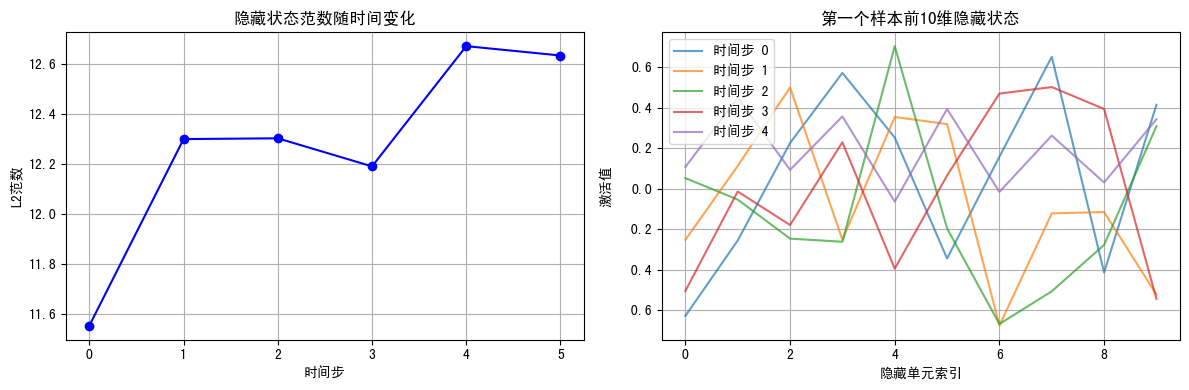

观察：隐藏状态在不同时间步下的变化反映了RNN的记忆能力


In [7]:
# 可视化隐藏状态的变化
plt.figure(figsize=(12, 4))
plt.rcParams['font.sans-serif'] = ['SimHei']

# 计算每个时间步隐藏状态的范数（衡量激活强度）
norms = [torch.norm(h).item() for h in hidden_states]

plt.subplot(1, 2, 1)
plt.plot(norms, 'bo-')
plt.title('隐藏状态范数随时间变化')
plt.xlabel('时间步')
plt.ylabel('L2范数')
plt.grid(True)

# 可视化隐藏状态的部分维度
plt.subplot(1, 2, 2)
for i in range(min(5, len(hidden_states))):
    plt.plot(hidden_states[i][0, :10].detach().numpy(), 
             label=f'时间步 {i}', alpha=0.7)
plt.title('第一个样本前10维隐藏状态')
plt.xlabel('隐藏单元索引')
plt.ylabel('激活值')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("观察：隐藏状态在不同时间步下的变化反映了RNN的记忆能力")

可以看到经过了 RNN 之后，隐藏状态的值已经被改变了，因为网络记忆了序列中的信息，同时输出了6个时间步的结果。

关键观察:
1. 记忆效应：每个时间步的隐藏状态都包含了之前所有时间步的信息
2. 状态演化：隐藏状态随时间逐步演化，体现了序列的动态特性
3. 信息整合：最后的隐藏状态包含了整个序列的信息摘要

In [8]:
## 使用 nn.RNN() 简化序列处理
##   下面我们看看直接使用 `nn.RNN()` 的情况，这种方式更加便捷：

# 定义一个完整的RNN网络
rnn_seq = nn.RNN(input_size=100, hidden_size=200, num_layers=1, batch_first=False)

print("RNN 网络参数:")
print("权重 ih (input to hidden):", rnn_seq.weight_ih_l0.shape)
print("权重 hh (hidden to hidden):", rnn_seq.weight_hh_l0.shape)
print("偏置 ih:", rnn_seq.bias_ih_l0.shape if rnn_seq.bias_ih_l0 is not None else "None")
print("偏置 hh:", rnn_seq.bias_hh_l0.shape if rnn_seq.bias_hh_l0 is not None else "None")

RNN 网络参数:
权重 ih (input to hidden): torch.Size([200, 100])
权重 hh (hidden to hidden): torch.Size([200, 200])
偏置 ih: torch.Size([200])
偏置 hh: torch.Size([200])


In [9]:
# 查看具体的权重值
print("Hidden to Hidden 权重矩阵 (前5x5):")
print(rnn_seq.weight_hh_l0[:5, :5])

Hidden to Hidden 权重矩阵 (前5x5):
tensor([[ 0.0537,  0.0458, -0.0005,  0.0703, -0.0633],
        [-0.0122,  0.0042, -0.0620, -0.0657,  0.0643],
        [ 0.0336, -0.0232,  0.0188, -0.0335, -0.0333],
        [-0.0282,  0.0063, -0.0401,  0.0467,  0.0459],
        [-0.0130,  0.0205,  0.0105, -0.0093, -0.0342]],
       grad_fn=<SliceBackward0>)


In [11]:
# 使用默认的全0隐藏状态处理序列
output, h_final = rnn_seq(x)  # x的形状是 (6, 5, 100)

print("RNN输出:")
print("所有时间步输出形状:", output.shape)  # (seq_len, batch, hidden_size)
print("最终隐藏状态形状:", h_final.shape)    # (num_layers, batch, hidden_size)

print("\n详细信息:")
print("序列长度:", output.shape[0])
print("批次大小:", output.shape[1])
print("隐藏层维度:", output.shape[2])

RNN输出:
所有时间步输出形状: torch.Size([6, 5, 200])
最终隐藏状态形状: torch.Size([1, 5, 200])

详细信息:
序列长度: 6
批次大小: 5
隐藏层维度: 200


In [ ]:
# 验证最后一个时间步的输出和最终隐藏状态是否相同
print("验证输出一致性:")
print("最后时间步的输出:", output[-1, 0, :5])  # 第一个样本的前5维
print("最终隐藏状态:", h_final[0, 0, :5])        # 第一层第一个样本的前5维
print("是否相等:", torch.allclose(output[-1], h_final[0]))

In [ ]:
这里的 `h_final` 是网络最后的隐藏状态，网络也输出了6个时间步的结果。

**重要理解**：
- `output` 包含了所有时间步的隐藏状态
- `h_final` 只包含最后一个时间步的隐藏状态
- 对于单层RNN，`output[-1]` 和 `h_final[0]` 是相同的

In [ ]:
## 自定义初始隐藏状态

我们也可以不使用默认的隐藏状态，而是自己定义初始隐藏状态：

# 自定义初始隐藏状态
h_0 = torch.randn(1, 5, 200)  # (num_layers, batch, hidden_size)
print("自定义初始隐藏状态形状:", h_0.shape)

# 使用自定义初始状态
output_custom, h_final_custom = rnn_seq(x, h_0)

print("\\n使用自定义初始状态的结果:")
print("输出形状:", output_custom.shape)
print("最终隐藏状态形状:", h_final_custom.shape)

# 比较使用不同初始状态的结果差异
print("\\n初始状态对结果的影响:")
print("默认初始化的最终状态前5维:", h_final[0, 0, :5])
print("自定义初始化的最终状态前5维:", h_final_custom[0, 0, :5])
print("两者差异:", torch.norm(h_final - h_final_custom).item())

In [ ]:
这里的隐藏状态的大小有三个维度，分别是 `(num_layers * num_directions, batch, hidden_size)`

**维度解释**：
- `num_layers`: RNN的层数
- `num_directions`: 方向数（单向为1，双向为2）
- `batch`: 批次大小
- `hidden_size`: 隐藏层维度

对于单层单向RNN，第一个维度就是1。

In [ ]:
## 多层RNN示例

让我们尝试一个更复杂的多层RNN：

# 创建一个2层的RNN
multi_layer_rnn = nn.RNN(input_size=100, hidden_size=200, num_layers=2, dropout=0.1)

print("多层RNN参数:")
print("第一层 weight_ih:", multi_layer_rnn.weight_ih_l0.shape)
print("第一层 weight_hh:", multi_layer_rnn.weight_hh_l0.shape)
print("第二层 weight_ih:", multi_layer_rnn.weight_ih_l1.shape)
print("第二层 weight_hh:", multi_layer_rnn.weight_hh_l1.shape)

# 为多层RNN创建初始隐藏状态
h_0_multi = torch.zeros(2, 5, 200)  # (num_layers=2, batch=5, hidden_size=200)

# 前向传播
output_multi, h_final_multi = multi_layer_rnn(x, h_0_multi)

print("\\n多层RNN输出:")
print("输出形状:", output_multi.shape)          # (seq_len, batch, hidden_size)
print("最终隐藏状态形状:", h_final_multi.shape)  # (num_layers, batch, hidden_size)

print("\\n各层最终隐藏状态:")
print("第一层最终状态 (前5维):", h_final_multi[0, 0, :5])
print("第二层最终状态 (前5维):", h_final_multi[1, 0, :5])

/tmp/ipykernel_812841/3685457895.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /croot/libtorch_1746637505019/work/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(X), torch.FloatTensor(y)
/tmp/ipykernel_812841/3685457895.py:44: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()


训练数据形状:
输入 X: torch.Size([100, 20])
目标 y: torch.Size([100, 20])


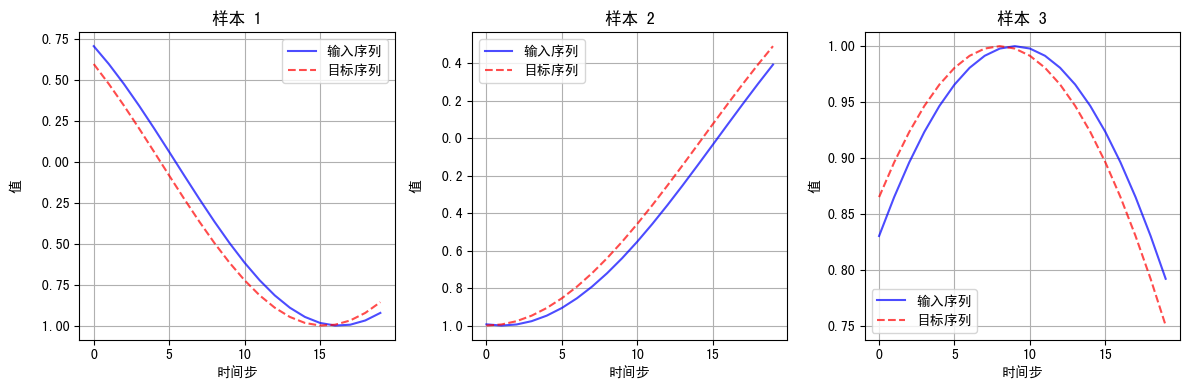

In [12]:
## RNN的实际应用示例
##   让我们通过一个简单的序列预测任务来理解RNN的实际应用：

# 创建一个简单的正弦波序列预测任务
def generate_sine_data(seq_len=50, num_samples=1000):
    """生成正弦波数据用于序列预测"""
    X, y = [], []
    
    for i in range(num_samples):
        # 随机起始点和频率
        start = np.random.random() * 2 * np.pi
        freq = np.random.random() * 0.1 + 0.05
        
        # 生成序列
        t = np.linspace(start, start + seq_len * freq, seq_len + 1)
        data = np.sin(t)
        
        X.append(data[:-1])  # 输入序列
        y.append(data[1:])   # 目标序列（向前移动一位）
    
    return torch.FloatTensor(X), torch.FloatTensor(y)

# 生成数据
seq_len = 20
X_train, y_train = generate_sine_data(seq_len=seq_len, num_samples=100)
print("训练数据形状:")
print("输入 X:", X_train.shape)  # (100, 20)
print("目标 y:", y_train.shape)  # (100, 20)

# 可视化几个样本
plt.figure(figsize=(12, 4))
plt.rcParams['font.sans-serif'] = ['SimHei']

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(X_train[i].numpy(), 'b-', label='输入序列', alpha=0.7)
    plt.plot(y_train[i].numpy(), 'r--', label='目标序列', alpha=0.7)
    plt.title(f'样本 {i+1}')
    plt.xlabel('时间步')
    plt.ylabel('值')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## 4. 实践建议

### 何时使用 nn.RNN() vs nn.RNNCell()

1. **使用 `nn.RNN()`**：
   - 处理固定长度的序列
   - 简化代码，避免手动循环
   - 需要利用PyTorch的自动优化
   - 大多数实际应用

2. **使用 `nn.RNNCell()`**：
   - 需要自定义循环逻辑
   - 变长序列处理
   - 需要在每个时间步进行特殊操作
   - 研究和调试目的

### 常见的RNN配置

一般情况下我们都是用 `nn.RNN()` 而不是 `nn.RNNCell()`，因为 `nn.RNN()` 能够避免我们手动写循环，非常方便。

**推荐设置**：
- 如果不特别说明，使用默认的全0初始化隐藏状态
- 对于大多数任务，单层RNN就足够了
- 如果需要更强的表达能力，考虑使用LSTM或GRU而不是堆叠更多RNN层

## 5. 练习思考

1. 为什么RNN适合处理序列数据而CNN不适合？
2. 梯度消失问题的数学本质是什么？
3. 如何选择RNN的隐藏层维度？
4. 在什么情况下你会选择使用多层RNN？


## 参考资料

* [Understanding RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) - Andrej Karpathy
* [机器学习——循环神经网络（RNN）](https://blog.csdn.net/beiye_/article/details/123526075)
* [循环神经网络讲解（RNN/LSTM/GRU）](https://zhuanlan.zhihu.com/p/123211148)
* [PyTorch RNN文档](https://pytorch.org/docs/stable/nn.html#rnn)
